# Pairwise mutation effects

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from promdis.processing import get_sequence_arrays_and_counts, gene_seq_to_array
from promdis.core import compute_pairwise_segmented_mean_expression

In [2]:
FPATH = "../data/expression_data/ykgE_dataset_combined.csv"

In [8]:
df = pd.read_csv(FPATH)
df['barcode'] = df['seq'].str.slice(160,)
df['promoter'] = df['seq'].str.slice(0, 160)
df

,ct,ct_0,ct_1,seq,barcode,promoter
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,GAGAGCCTCGCGTATCCCTC,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,GGATCCATGGTCATTCGGTG,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,TATTACGGTACGAGATTGCT,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,AACTCTCACTCTGCTGTACG,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,TACCCGTGTTCGTAACCCCT,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
...,...,...,...,...,...,...
2585,1.0,1.0,0.0,TTGTTTTCGCCATAAATTGTGAGCGATGCCGTAAGAAACAAAATTA...,CGCATACGGTAGAAGCGGAA,TTGTTTTCGCCATAAATTGTGAGCGATGCCGTAAGAAACAAAATTA...
2586,2.0,1.0,1.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,CGTCCTTTACGTACTATGGG,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...
2587,1.0,1.0,0.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,CACGTCAGCGGCCCTCTTAC,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...
2588,1.0,1.0,0.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,GTATCCGTGCGACCATCCAA,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...


In [86]:
seqs, counts_dna, counts_rna = get_sequence_arrays_and_counts(
    df, key_promoter='promoter', key_rna='ct_1', key_dna='ct_0'
)

expression = counts_rna / (counts_dna + counts_rna)

In [87]:
# Load wildtype data

GENE = 'ykgE'

WT_GENES_FPATH = "../data/wtsequences.csv"

wildtype_genes_df = pd.read_csv(WT_GENES_FPATH)

WT_GENE_SEQUENCES = {
    g: wildtype_genes_df.loc[wildtype_genes_df['name'] == g,'geneseq'].values[0]
    for g in wildtype_genes_df['name'].unique()
}

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]

nbases = len(GENE_WT_SEQ)
print(f"{GENE} wildtype sequence (length {nbases}):\n", GENE_WT_SEQ)

ykgE wildtype sequence (length 160):
 TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG


In [89]:
wt_seq = gene_seq_to_array(GENE_WT_SEQ)

xi = compute_pairwise_segmented_mean_expression(
    seqs, expression, wt_seq, 1
)

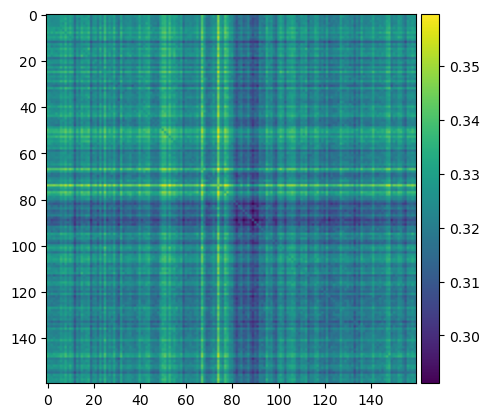

In [90]:
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(xi[0,0])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)


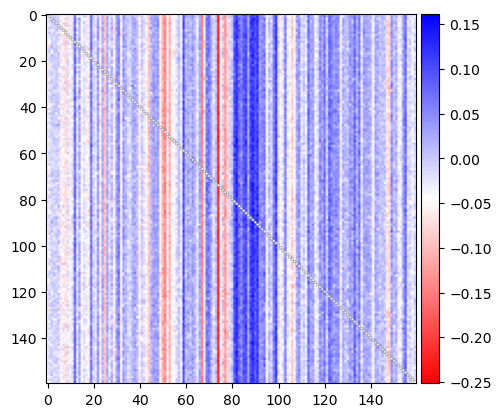

In [95]:
# gamma = (xi[0,1] + xi[0,2]) / 2 - xi[0,0]
gamma = xi[0, 1] - xi[0, 0]
# assert np.allclose(gamma, gamma.T)
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(gamma, cmap='bwr_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)


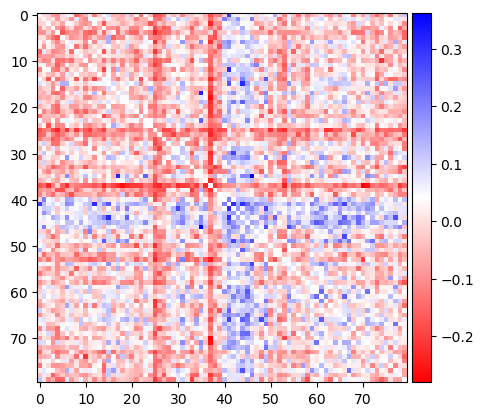

In [84]:
gamma = (xi[1,1] + xi[1,2] + xi[2, 1] + xi[2,2]) / 4 - xi[0,0]
# assert np.allclose(gamma, gamma.T)
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(gamma, cmap='bwr_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)


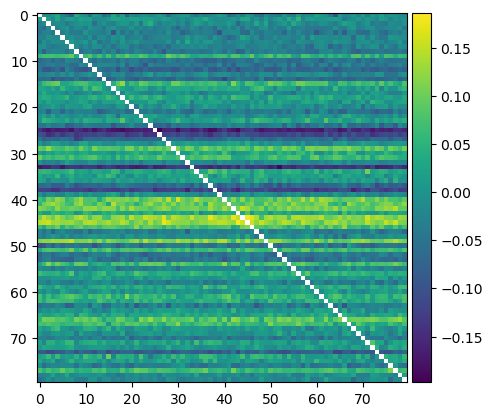

In [44]:
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(xi[1,0] - xi[0,0])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)